<h1 align="center"> Practical Project 1 - Modelling of a 2-Step SAR-based ADC </h1>

<p align="justify">
    In this first project the goal is to develop an high-level model of a 2-step pipeline ADC based on sub SAR-ADCs. The sub ADCs feature loop-unrolling, using a comparator for each bit extraction in an assynchronous fashion for each successive bit, reducing the timing diagram of the SAR-ADCs to a single conversion period and a single reset period.
</p>

<h2 align="left"> Sub-ADC Operation </h2>
<p align="center">
    <img src="../docs/imgs/sub_adc_paper1.png" width=500>
</p>

<p align="justify">
The operation of the sub loop-unrolled SAR-ADC must be understood in order to proceed with the modelling activity. A few important notes can be taken from the figure above:

<ul align="left">

<il> 1 - The SAR-ADC uses an assynchronous comparator for the extraction of each bit (loop-unrolling technique) - not the classical architecture of a single comparator for all bits; </il>

<il> 2 - The differential architecture of the SAR-ADC enables to extract the Most Significant Bit for free right after sampling, without using the DAC capacitive arrays, using comparator D5; </il>

<il> 3 - The SAR-ADC is performing bottom-sampling to sample the input differential signal, and as such, the first step after sampling is encharged of transposing the input signal from the bottom plate to the top plate of the capacitors of the DAC array, where the comparators are connected to; </il>

<il> 4 - The capacitive DAC arrays feature a split-capacitor architecture, unfolding the capacitance of each element in half. This enables the split capacitor to have one of its bottom plates connected to VREF- and the other to VREF+ at all times during bit extraction - thus allowing the voltage at the top plate of the capacitor array to stay relatively stable around the common mode voltage VCM. The stability of the top plate voltage around VCM is very important to maintain the correct operation and operating point of the comparators D<5:0>.</il>

<il> 5 - After each bit decision, if the current bit is a logical "1", then the bottom plates of the corresponding positive(top)-array split-capacitor are connected to VREF+ / VREF-, and consequently the bottom plates of the corresponding negative(bottom)-array split-capacitor are connected to VREF- / VREF+, symmetrically. This will pull the top plate voltage of the positive capacitor array upwards, and pull the top plate voltage of the negative capacitor array downwards, adjusting the decision scale for each comparator. </il>



<il> If the current bit is decided to be a logical "0", then the symmetrical connections will be performed. In this case, the top plate voltage of the positive capacitor array will be pulled downwards, and the top plate voltage of the negative capacitor array will be pushed upwards, once again adjusting the decision scale for each comparator. </il> 
</ul>

<il> The last Cs capacitor, presenting the lowest weight of the array is also programmed! Usually, this capacitor is not programmed, but to enable pipeline operation, the Residue voltage must be available at the top plate of the </il>

Note that: bit D5 will influence the connections of the 8C+8C split capacitor (which decides bit D4); bit D4 will influence the connections of the 4C+4C split capacitor (which decides bit D3), and etc. ...

</p>

<h2 align="left"> Timing Diagram of sub SAR-ADC </h2>

<p align="center">
    <img src="../docs/imgs/sub_adc_paper1_timing_diagram.png" width=500 />
</p>

In [325]:
# set up required imports
from functools import partial

# mathematical computing
import numpy as np
import scipy as sp
from scipy import signal # to generate the noise signal
import seaborn as sns # to observe the noise signal's histogram

sns.set_theme()
sns.set_palette("colorblind")

from numpy.random import uniform, normal # random numbers fitted into a uniform distribution
# plotting
import matplotlib.pyplot as plt
# import the models and utilities functions
from utils import ideal_dac, ideal_adc, nonideal_adc, dec2bin, bin2dec

%matplotlib inline

In [326]:
# setup the time base for the input signal
# number of simulation points
Np = 2**15
# define the time base
Fs = 1e9 # Hz
Ts = 1/Fs # s
tD = np.arange(0,Np)*Ts; # (0:Np-1) == np.arange(0,Np)

In [327]:
# setup the ADC parameters
vdd     = 1.0
vss     = 0.0
vcm     = np.mean([vdd, vss])
vrefp   = vdd
vrefn   = vss

vref    = vdd   # reference voltage of the whole 2-step adc

# first sub ADC
vref_first  = vref
Nbits_first = 6
vlsb_first  = vref_first/(2**Nbits_first)

# second sub ADC
vref_second     = vref/4
Nbits_second    = 7
vlsb_second     = vref_second/(2**Nbits_second)

In [328]:
# scales
# volts 
V   = 1.0
mV  = V*1e-3
uV  = V*1e-6
nV  = V*1e-9

# seconds
s  = 1.0
ms = s*1e-3
us = s*1e-6
ns = s*1e-9

# frequency
Hz = 1.0
kHz = Hz*1e3
MHz = Hz*1e6
GHz = Hz*1e9

# length
m  = 1.0
mm = m*1e-3
um = m*1e-6
nm = m*1e-9

# farad
F  = 1.0
pF = F*1e-12
fF = F*1e-15

### ENABLE NOISE SIMULATION

In [329]:
ENABLE_NOISE = True # enable noise supperposed to the input signal
vn_mean = 0.0*V     # mean of the noise signal
vn_std  = 1*mV    # standard deviation of the noise signal
vn_in   = normal(vn_mean, vn_std**2, Np) # generate the gaussian/white (random) noise signal

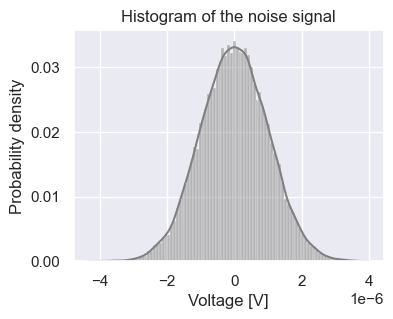

In [330]:
# observe the noise signal
if ENABLE_NOISE:
    fig, ax = plt.subplots(figsize=(4,3))
    sns.histplot(vn_in, ax=ax, kde=True, stat='probability', color='gray', label='noise signal')
    ax.set_xlabel('Voltage [V]')
    ax.set_ylabel('Probability density')
    ax.set_title('Histogram of the noise signal')
    plt.show()

# Sub SAR-ADC transfer function

<p align="justify">
The general analog to digital transfer function Dout(Vin) of the sub SAR-ADC can be derived using the charge conservation principle (CCP) to derive the voltage at the top plate of the capacitor arrays in each step of the conversion process.

There are two main approaches: the long form, that actually describes the true operation of the capacitor arrays, or the short form, simplifying the analysis regarding the modelling of the capacitor arrays when writting the code.

<ul>

<il> The long form implies applying the CCP to the sampling phase and each of the corresponding phases of each extracted bit, taking into account all the capacitors connected to each array;</il>

<il>The short form implies applying the CCP to each pair of successive phases of each bit extraction, taking only into account the capacitance associated to the changed bottom plate connections.</il>

</ul>

</p>

In [331]:
# setup the input signal of the first sub ADC
A1      = vref/2
fbin    = 1
f1      = fbin*(Fs/Np)
ph1    = 0
vin1t   = A1*np.sin(2*np.pi*f1*tD + ph1) + vcm
if ENABLE_NOISE:
    vin1t = vin1t + vn_in

# compute the spectrum of the input signal
vin1f           = np.abs(np.fft.fftshift(np.fft.fft(vin1t) / Np))  # [V] # voltage in the frequency axis
# NOTE: fft(yf) is divided by Np in order to normalize the resulting frequency spectrum from the digital fourier transform
fD              = np.fft.fftshift(np.fft.fftfreq(Np, Ts))  # [Hz] # frequency axis
power_vin1f     = (vin1f*vin1f) # [V^2] - square the voltage spectrum to obtain the power spectrum
power_vinf_dB   = 10 * np.log10(power_vin1f)  # [dB] - convert the power spectrum to dB


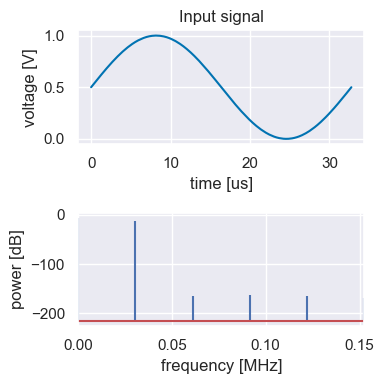

In [332]:
# observe the input signal in time and frequency
fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(tD/us, vin1t, label='input signal in time')
ax[0].set_xlabel('time [us]')
ax[0].set_ylabel('voltage [V]')
ax[0].set_title('Input signal')
ax[0].grid(True)
ax[1].stem(
    fD[fD>=0]/MHz, 
    power_vinf_dB[fD>=0], 
    label='input signal in frequency', 
    bottom=np.min(power_vinf_dB), 
    linefmt="b-",
    markerfmt="none",
    basefmt="r-"
)
ax[1].grid(True)
ax[1].set_xlabel('frequency [MHz]')
ax[1].set_ylabel('power [dB]')
# close up on the frequency axis
ax[1].set_xlim([0, 5*f1/MHz])
plt.tight_layout()
plt.show()

In [334]:
# setup mponte carlo analysis
Ncircuits = 100 # number of circuits in monte carlo simulation

sub_adc_lins = []
sub_adc_avg_lin = [] 

# setup comparator offset
Num_comp_offsets    = 10    # number of comparator offsets to be simulated
comp_offsets        = np.linspace(0, 1*mV, Num_comp_offsets) # [V] # array of comparator offsets

# setup the capacitor mismatch error for the monte carlo sim
cap_err_mean    = 0.0
sigma_factor    = 3
sigma_cap_err   = 0.02  # 5% capacitor mismatch
std_cap_err     = sigma_cap_err * sigma_factor


for comp_offset in comp_offsets:
    for _ in range(Ncircuits):
        # setup the splitted capacitor DAC arrays
        # positive array
        # generate the unitary capacitor array
        # even indexes
        cap_err_even         = normal(cap_err_mean, std_cap_err**2, 2**(Nbits_first-2)) # [F] # capacitor mismatch error
        unittary_caps   = np.ones(len(cap_err_even))*(1 + cap_err_even) # [F] # array of unitary capacitors
        # generate the binary weighted capacitor array
        pos_cap_even    = np.array([ np.sum(unittary_caps[0:i]) for i in range(len(unittary_caps)+1) ]) # [F] 
        # odd indexes
        cap_err_odd     = normal(cap_err_mean, std_cap_err**2, 2**(Nbits_first-2)) # [F] # capacitor mismatch error
        unittary_caps   = np.ones(len(cap_err_odd))*(1 + cap_err_odd) # [F] # array of unitary capacitors
        # generate the binary weighted capacitor array
        pos_cap_odd     = np.array([ np.sum(unittary_caps[ 2**(b)-1: 2**b ]) for b in range(Nbits_first) ]) # [F] 
        